<a href="https://colab.research.google.com/github/GonzaloMA-17/k_brazos_FJLGM/blob/main/notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Asignatura**: Extensiones de Machine Learning, 2024/2025

**Alumnos**:<br>
- Gonzalo Marcos Andrés (gonzalo.marcosa@um.es)
- Francisco José López Fernández (franciscojose.lopezf@um.es)

**Máster de Inteligencia Artificial**

| **Facultad de Informática** | **Universidad de Murcia** |
|-----------------------------|---------------------------|
| ![](https://www.um.es/image/layout_set_logo?img_id=175281&t=1726728636242) | ![](https://www.um.es/o/um-lr-principal-um-home-theme/images/logo-um.png) |

# Estudio comparativo de algoritmos en un problema de bandido de k-brazos

### Resolución del Problema con Algoritmos Softmax

En este estudio, abordaremos el problema del bandido de k-brazos utilizando algoritmos Softmax. Este enfoque es una alternativa a los algoritmos epsilon-greedy y se basa en la probabilidad de seleccionar cada brazo en función de su valor estimado.

#### Algoritmos Softmax

A diferencia de los algoritmos epsilon-greedy, que seleccionan el mejor brazo conocido con una alta probabilidad y exploran otros brazos con una pequeña probabilidad, los algoritmos Softmax asignan una probabilidad a cada brazo basada en su valor estimado. Esto permite una exploración más equilibrada y puede mejorar el rendimiento en ciertos escenarios.

#### Objetivos del Estudio

En este estudio, compararemos el rendimiento de diferentes configuraciones del algoritmo Softmax en un entorno de bandido de 10 brazos. Para ello, realizaremos múltiples ejecuciones del experimento y generaremos las siguientes gráficas:

1. **Porcentaje de Selección del Brazo**: Mostraremos cómo varía el porcentaje de veces que cada brazo es seleccionado a lo largo del tiempo.
2. **Estadísticas de Cada Brazo**: Presentaremos el promedio de las ganancias obtenidas por cada brazo, lo que nos permitirá evaluar la efectividad de las selecciones.
3. **Evolución del Rechazo**: Analizaremos cómo evoluciona el rechazo acumulado (diferencia entre la recompensa óptima y la recompensa obtenida) a lo largo del tiempo.

Estas visualizaciones nos permitirán entender mejor el comportamiento de los algoritmos Softmax y su capacidad para equilibrar la exploración y la explotación en el problema del bandido de k-brazos.


## Preparación del entorno

**Clonación del repositorio:**

Para poder acceder a todas las clases y métodos necesarios.

In [8]:
# !git clone https://github.com/GonzaloMA-17/k_brazos_FJLGM.git

In [1]:
# %cd k_brazos_FJLGM

### Librerías

In [2]:
import numpy as np
from typing import List

from src_algorithms import Algorithm, Softmax, GradientPreference
from src_arms import *
from src_plotting import *

Semilla:

In [3]:
seed = 1234

**Definición del experimento:**

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado. Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos Softmax con diferentes valores de temperatura. Se estudia la evolución de cada política en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recompensas obtenidas en esas 500 veces.

In [4]:
def run_experiment_complete(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):
    optimal_arm = bandit.optimal_arm
    optimal_reward = bandit.arms[optimal_arm].get_expected_value()  # Obtener la recompensa esperada del brazo óptimo

    rewards = np.zeros((len(algorithms), steps))  # Matriz para almacenar las recompensas promedio.
    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.
    arm_rewards = np.zeros((len(algorithms), bandit.k))  # Matriz para almacenar las recompensas acumuladas por brazo.
    arm_counts = np.zeros((len(algorithms), bandit.k))  # Matriz para almacenar el número de selecciones por brazo.
    selections_per_algorithm = np.zeros((len(algorithms), bandit.k))  # Matriz para contar selecciones por brazo.
    regret_accumulated = np.zeros((len(algorithms), steps))  # Matriz para almacenar el rechazo acumulado.

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset()  # Reiniciar los valores de los algoritmos.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()  # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm)  # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward)  # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward  # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                selections_per_algorithm[idx, chosen_arm] += 1

                arm_rewards[idx, chosen_arm] += reward  # Acumular la recompensa obtenida en arm_rewards para el brazo chosen_arm.
                arm_counts[idx, chosen_arm] += 1  # Incrementar el conteo de selecciones para el brazo chosen_arm.

                # Modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Calcular el rechazo acumulado
                regret_accumulated[idx, step] += optimal_reward - reward

    rewards /= runs

    # Calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100

    # Calcular el promedio de ganancias de cada brazo
    average_rewards = arm_rewards / np.maximum(arm_counts, 1)

    # Calcular el rechazo acumulado promedio
    regret_accumulated = np.cumsum(regret_accumulated, axis=1) / runs

    # Preparar las estadísticas de los brazos
    arm_stats = [{'average_rewards': average_rewards[idx], 'selection_counts': arm_counts[idx]} for idx in range(len(algorithms))]

    return rewards, optimal_selections, arm_stats, regret_accumulated

**Ejecución del experimento**:

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución Bernoulli de probabilidad **p**. 

Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan dos algoritmos de la familia de **Ascenso del gradiente**: 

- *Softmax*
- *Gradiente de preferencias*.

In [5]:
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBernoulli.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [Softmax(k=k, tau=0.1),Softmax(k=k, tau=1), GradientPreference(k=k, alpha=0.1), GradientPreference(k=k, alpha=0.5)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, arm_stats, regret_accumulated = run_experiment_complete(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBernoulli(p=0.25), ArmBernoulli(p=0.6), ArmBernoulli(p=0.45), ArmBernoulli(p=0.72), ArmBernoulli(p=0.73), ArmBernoulli(p=0.32), ArmBernoulli(p=0.74), ArmBernoulli(p=0.87), ArmBernoulli(p=0.8), ArmBernoulli(p=0.39)
Optimal arm: 8 with expected reward=0.87


En el contexto del problema del bandido de 10 brazos con distribución Bernoulli, cada brazo tiene una probabilidad asociada de proporcionar una recompensa de 1. En este caso, los brazos tienen las siguientes probabilidades de éxito.

El brazo óptimo es el que tiene la mayor probabilidad de éxito, en este caso, el brazo 8 con una probabilidad de 0.87. Esto significa que, en promedio, este brazo proporcionará una recompensa de 1 en el 87% de las veces que se seleccione.

*Consideraciones*: 

- Recompensas Menores a 1: Las recompensas promedio obtenidas por los algoritmos Softmax y Gradiente de Preferencias son menores a 1 debido a la naturaleza probabilística de las recompensas de los brazos Bernoulli. Incluso el brazo óptimo no garantiza una recompensa de 1 en cada intento, sino que tiene una probabilidad de 0.87 de proporcionar una recompensa de 1 y una probabilidad de 0.13 de proporcionar una recompensa de 0.

#### Algoritmos Softmax y Gradiente de Preferencias

Estos algoritmos están diseñados para equilibrar la exploración y la explotación. A lo largo de múltiples ejecuciones y pasos, los algoritmos intentan identificar el brazo óptimo, pero también exploran otros brazos para asegurarse de que no se pierdan posibles recompensas altas de otros brazos. Esta exploración adicional puede llevar a seleccionar brazos subóptimos en algunas ocasiones, lo que reduce la recompensa promedio observada. 

**Visualización de resultados**:

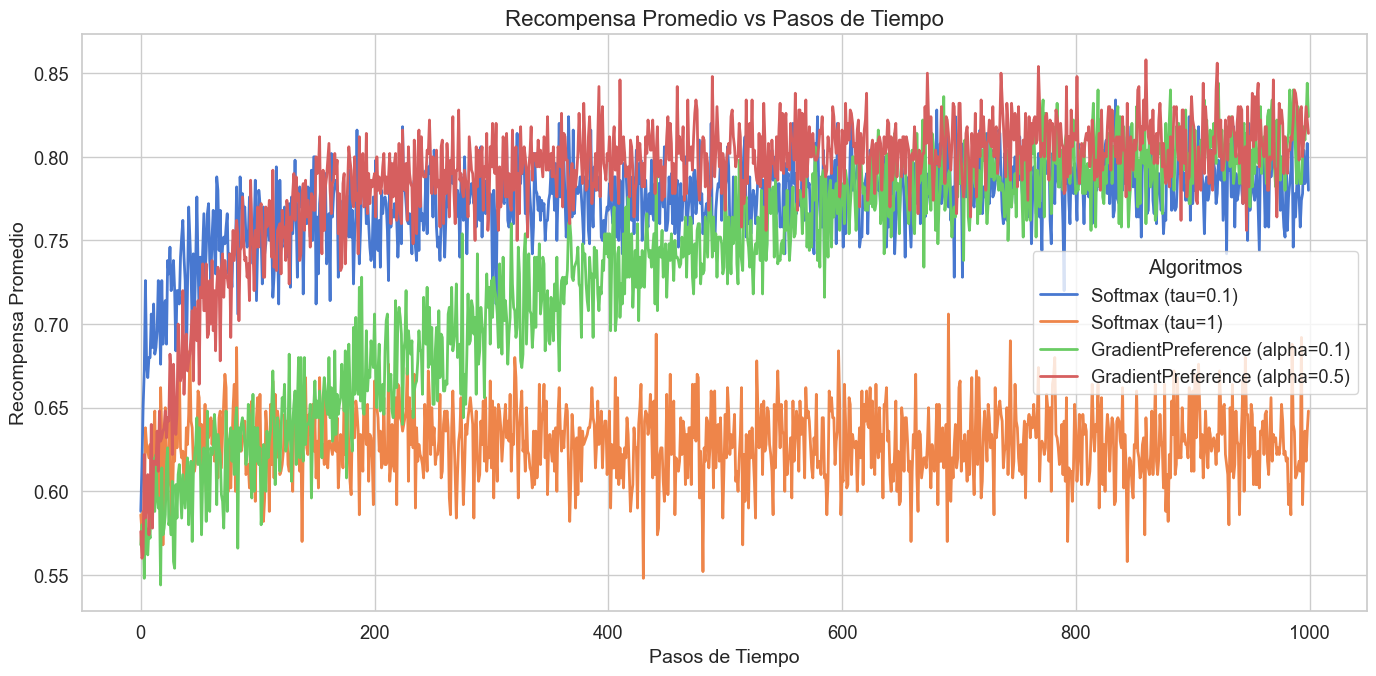

In [6]:
# Graficar los resultados
plot_average_rewards(steps, rewards, algorithms)

**Análisis de la Recompensa Promedio en Función del Tiempo**

**Descripción de los Algoritmos y Configuraciones:**

- **Softmax (τ = 0.1) - Azul**: Baja exploración, favorece la explotación temprana.
- **Softmax (τ = 1) - Naranja**: Mayor exploración, lo que permite evaluar más opciones antes de explotar.
- **Gradiente de Preferencias (α = 0.1) - Verde**: Tasa de aprendizaje baja, lo que permite un ajuste gradual y estable de las preferencias.
- **Gradiente de Preferencias (α = 0.5) - Rojo**: Tasa de aprendizaje alta, lo que permite una adaptación rápida pero puede llevar a convergencia prematura en una política subóptima.

**Análisis de Resultados**

1. **Crecimiento y Convergencia de la Recompensa Promedio**

- **Softmax (τ = 0.1) - Azul**: Inicialmente, su recompensa promedio crece de manera estable y alcanza un buen rendimiento. Sin embargo, su baja exploración podría impedir que encuentre la mejor opción global.
  
- **Softmax (τ = 1) - Naranja**: Al permitir mayor exploración, este algoritmo tiene un desempeño inferior en términos de recompensa promedio. Muestra fluctuaciones notables, lo que sugiere que la alta exploración impide la explotación efectiva de los mejores brazos.

- **Gradiente de Preferencias (α = 0.1) - Verde**: Este algoritmo obtiene una recompensa promedio alta. Su menor tasa de aprendizaje permite una convergencia más estable y efectiva hacia los brazos óptimos. Muestra un crecimiento constante y alcanza una recompensa promedio estable. Su tasa de aprendizaje baja evita cambios bruscos y permite un ajuste progresivo, asegurando una buena explotación.

- **Gradiente de Preferencias (α = 0.5) - Rojo**: Con una tasa de aprendizaje alta, este algoritmo converge más rápido y alcanza una recompensa promedio alta. Su mayor tasa de aprendizaje ajusta las preferencias rápidamente, lo que permite identificar y explotar el brazo óptimo de manera eficiente. Es el algoritmo que logra la mejor recompensa promedio final. Gracias a su alta tasa de aprendizaje, converge rápidamente hacia las opciones más óptimas, mostrando una tendencia estable en el tiempo.

2. **Equilibrio entre Exploración y Explotación**

- **Gradiente de Preferencias** ajusta dinámicamente las probabilidades de selección de los brazos, lo que resulta en un mejor desempeño en términos de recompensa promedio.Además demuestra el mejor balance entre exploración y explotación, permitiendo alcanzar un alto rendimiento en menos tiempo.
- **Softmax** utiliza una estrategia de exploración controlada por temperatura (τ), pero su rendimiento es inferior al de Gradiente de Preferencias en este experimento. Ya que Softmax (τ = 1) evidencia los efectos de una exploración excesiva, ya que su recompensa promedio es baja y fluctuante, y Softmax (τ = 0.1) y Gradiente de Preferencias (α = 0.1) son estrategias más conservadoras, con un crecimiento estable pero más lento.

**Conclusiones**

- El mejor desempeño se obtuvo con Gradiente de Preferencias (α = 0.5), que alcanzó la mayor recompensa promedio con rápida convergencia.
- Softmax (τ = 1) mostró el peor desempeño debido a su alta exploración, que impidió una explotación eficiente.
- Softmax (τ = 0.1) logró una recompensa decente, pero su falta de exploración podría hacer que no siempre encuentre la mejor opción.
- Gradiente de Preferencias (α = 0.1) fue estable, aunque más lento en alcanzar su mejor recompensa.
- Para maximizar la recompensa a largo plazo, es crucial encontrar un buen balance entre exploración y explotación.


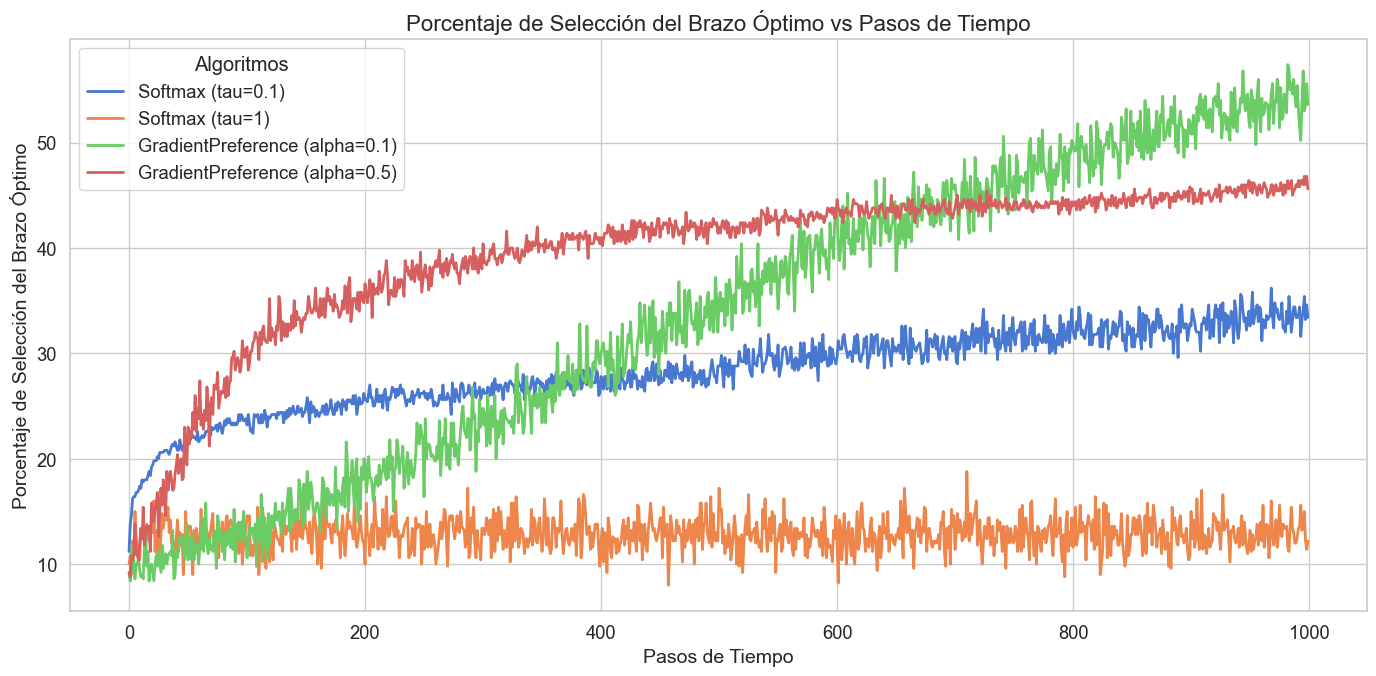

In [7]:
plot_optimal_selections(steps, optimal_selections, algorithms)

**Explicación de los Resultados de la Gráfica de Porcentajes de Selección de los Brazos Óptimos**

La gráfica de porcentajes de selección de los brazos óptimos muestra cómo cada algoritmo explora y explota los brazos del bandido a lo largo del tiempo. A continuación, se detallan los resultados observados para los cuatro algoritmos probados:

1. **Softmax (τ = 0.1) - Línea Azul**:
    - Este algoritmo tiene una temperatura baja, lo que significa que favorece la explotación sobre la exploración.
    - La línea azul muestra un crecimiento gradual en el porcentaje de selección del brazo óptimo, indicando que el algoritmo explora menos y se enfoca más en los brazos que inicialmente parecen prometedores.
    - A largo plazo, el algoritmo logra identificar el brazo óptimo, pero lo hace de manera más lenta en comparación con otros algoritmos con mayor exploración.

2. **Softmax (τ = 1) - Línea Naranja**:
    - Con una temperatura más alta, este algoritmo permite una mayor exploración.
        - La línea naranja muestra un crecimiento más rápido en el porcentaje de selección del brazo óptimo en comparación con τ = 0.1 debido a su mayor exploración.
        - Sin embargo, esta exploración excesiva también lleva a seleccionar brazos subóptimos con mayor frecuencia, lo que resulta en un peor rendimiento general en términos de recompensa promedio.

3. **Gradiente de Preferencias (α = 0.1) - Línea Verde**:
    - Este algoritmo tiene una tasa de aprendizaje baja, lo que significa que ajusta sus preferencias de manera más lenta.
    - La línea verde muestra un crecimiento moderado en el porcentaje de selección del brazo óptimo.
    - Aunque el algoritmo eventualmente converge hacia el brazo óptimo, lo hace a un ritmo más lento debido a la menor tasa de aprendizaje.

4. **Gradiente de Preferencias (α = 0.5) - Línea Roja**:
    - Con una tasa de aprendizaje alta, este algoritmo ajusta sus preferencias rápidamente.
    - La línea roja muestra un crecimiento rápido y consistente en el porcentaje de selección del brazo óptimo.
    - Este algoritmo es el más eficiente en identificar y explotar el brazo óptimo, alcanzando un alto porcentaje de selección en menos tiempo.



### Arrepentimiento acumulado

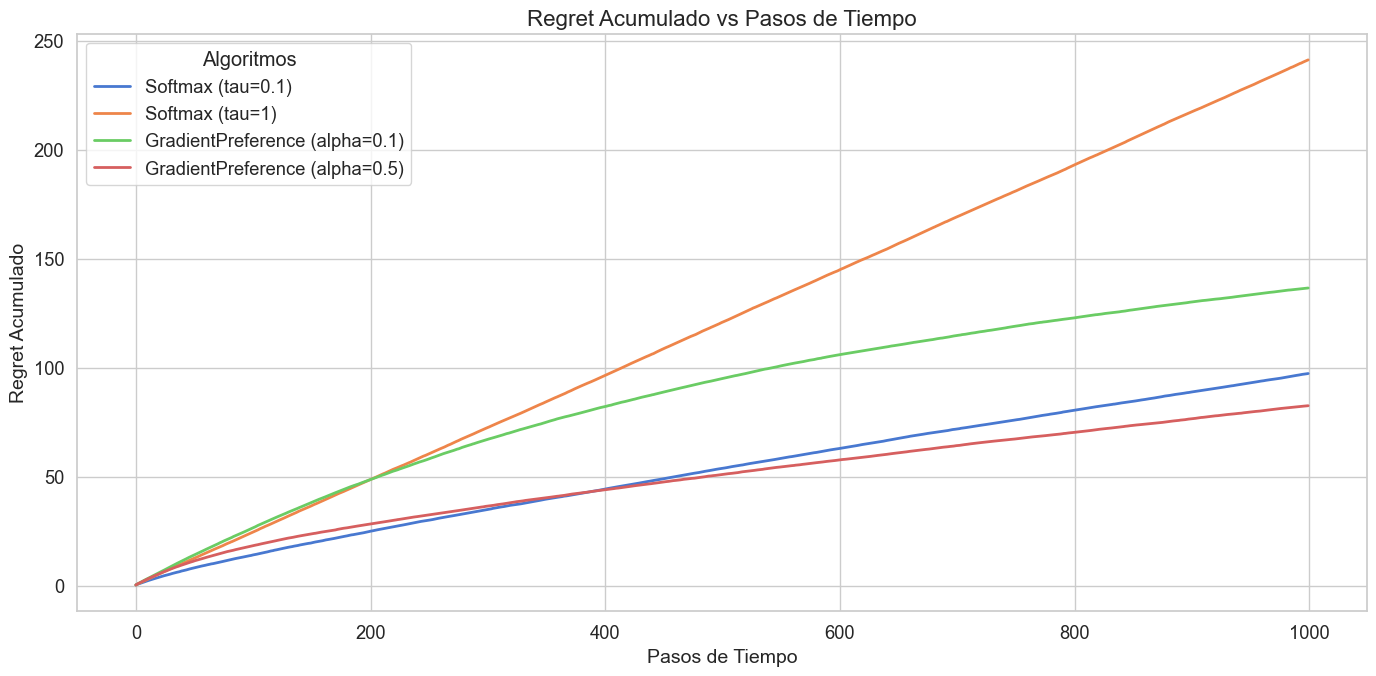

In [9]:
plot_regret(steps, regret_accumulated, algorithms)

La gráfica de arrepentimiento acumulado muestra cómo cada algoritmo se desempeña en términos de la diferencia acumulada entre la recompensa óptima y la recompensa obtenida a lo largo del tiempo. A continuación, se detalla el comportamiento observado para cada uno de los algoritmos probados:

1. **Softmax (τ = 0.1) - Línea Azul**:
    - El arrepentimiento acumulado crece de manera constante pero a un ritmo más lento en comparación con el resto de algoritmos.
    - Debido a su baja exploración, este algoritmo tiende a explotar los brazos que inicialmente parecen prometedores, lo que puede llevar a un arrepentimiento menor en las primeras etapas, pero puede no identificar el brazo óptimo rápidamente.

2. **Softmax (τ = 1) - Línea Naranja**:
    - Con una temperatura más alta, este algoritmo permite una mayor exploración.
    - En este caso muestra un arrepentimiento acumulado que crece más rápidamente en las primeras etapas debido a la mayor exploración.

3. **Gradiente de Preferencias (α = 0.1) - Línea Verde**:
    - Este algoritmo tiene una tasa de aprendizaje baja, lo que significa que ajusta sus preferencias de manera más lenta.
    - La línea verde muestra un arrepentimiento acumulado que crece de manera moderada.
    - Aunque el algoritmo eventualmente converge hacia el brazo óptimo, lo hace a un ritmo más lento debido a la menor tasa de aprendizaje, lo que resulta en un arrepentimiento acumulado mayor en comparación con una tasa de aprendizaje más alta.

4. **Gradiente de Preferencias (α = 0.5) - Línea Roja**:
    - Con una tasa de aprendizaje alta, este algoritmo ajusta sus preferencias rápidamente.
    - La línea roja muestra un arrepentimiento acumulado que crece rápidamente al principio pero se estabiliza más rápidamente que los otros algoritmos.
    - Este algoritmo es el más eficiente en identificar y explotar el brazo óptimo, lo que resulta en un arrepentimiento acumulado menor a largo plazo.


### Conclusiones

- **Exploración vs Explotación**: Los algoritmos con mayor exploración, como Softmax con τ = 1 y Gradiente de Preferencias con α = 0.5, tienden a identificar el brazo óptimo más rápidamente. Sin embargo, una exploración excesiva puede llevar a seleccionar brazos subóptimos en las primeras etapas del experimento, lo que puede resultar en un mayor arrepentimiento acumulado inicial. Por otro lado, algoritmos con menor exploración, como Softmax con τ = 0.1, tienden a explotar los brazos que inicialmente parecen prometedores, lo que puede llevar a una convergencia más lenta hacia el brazo óptimo.

- **Tasa de Aprendizaje**: En el caso del Gradiente de Preferencias, un mayor valor de α permite un ajuste más rápido y eficiente de las preferencias, resultando en una identificación más rápida del brazo óptimo. Sin embargo, una tasa de aprendizaje demasiado alta puede llevar a una convergencia prematura en una política subóptima. En este estudio, se observó que Gradiente de Preferencias con α = 0.5 logró un equilibrio adecuado entre exploración y explotación, permitiendo una rápida identificación y explotación del brazo óptimo.

- **Temperatura en Softmax**: La temperatura en el algoritmo Softmax controla el equilibrio entre exploración y explotación. Una temperatura más alta (τ = 1) permite una mejor exploración inicial, lo que puede ayudar a identificar el brazo óptimo más rápidamente. Sin embargo, una temperatura demasiado baja (τ = 0.1) puede llevar a una explotación prematura y subóptima, ya que el algoritmo tiende a seleccionar los brazos que inicialmente parecen prometedores sin explorar adecuadamente otras opciones.

El algoritmo Gradiente de Preferencias con α = 0.5 demostró ser el más efectivo para identificar y explotar el brazo óptimo rápidamente en el contexto del problema del bandido de 10 brazos con distribución Bernoulli. Este algoritmo logró un equilibrio adecuado entre exploración y explotación, permitiendo una rápida convergencia hacia el brazo óptimo y minimizando el arrepentimiento acumulado a largo plazo. Por otro lado, Softmax con τ = 1 también mostró un buen desempeño en términos de exploración inicial, pero no fue tan eficiente como Gradiente de Preferencias con α = 0.5 en términos de recompensa promedio y arrepentimiento acumulado. Los algoritmos con menor exploración o tasa de aprendizaje, como Softmax con τ = 0.1 y Gradiente de Preferencias con α = 0.1, tardaron más en converger hacia el brazo óptimo y mostraron un mayor arrepentimiento acumulado.